<a href="https://colab.research.google.com/github/sir-sauc3/comp215-Project1/blob/main/Sos%26Roberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
# this is our key: k_w26fb6h9
# api url top 250 movies: https://imdb-api.com/en/API/Top250Movies/k_w26fb6h9
# api url for movie casst: https://imdb-api.com/en/API/FullCast/k_w26fb6h9/${movie ID}


In [75]:
import json, requests
from pprint import pprint
from dataclasses import dataclass
import matplotlib.pyplot as plt
import networkx as nx

In [76]:
@dataclass
class Actor:
  name : str
  id : str
  image : str

  @classmethod
  def createActor(cls, name, id, image):
    return cls(name, id, image)
    

@dataclass
class Movie:
  title : str
  id : str
  image: str

  @classmethod
  def createMovie(cls, title, id, image):
    return cls(title, id, image)

In [77]:
API_KEY = 'k_w26fb6h9'

url = f'https://imdb-api.com/en/API/Top250Movies/k_w26fb6h9'

response = requests.request("GET", url, headers={}, data={})

data = json.loads(response.text)
# pprint(data)

movies = [(movie['title'],
          movie['id'],
          movie['image']) for movie in data['items']]


# pprint(movies)


# movies = [[data['items'][i]['title'], 
#            data['items'][i]['id'], 
#            [data['items'][i]['image']]
#            ] for i in range(len(data['items']))]

In [78]:
movie_items = [data for data in data['items']]
pprint(movie_items)

#collects last two crew members (actors) from 'crew' key in items
crew = [[crew['crew'].split(', ')[-2], crew['crew'].split(', ')[-1]] for crew in data['items']]
# pprint(crew)

[{'crew': 'Frank Darabont (dir.), Tim Robbins, Morgan Freeman',
  'fullTitle': 'The Shawshank Redemption (1994)',
  'id': 'tt0111161',
  'imDbRating': '9.2',
  'imDbRatingCount': '2700183',
  'image': 'https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_UX128_CR0,3,128,176_AL_.jpg',
  'rank': '1',
  'title': 'The Shawshank Redemption',
  'year': '1994'},
 {'crew': 'Francis Ford Coppola (dir.), Marlon Brando, Al Pacino',
  'fullTitle': 'The Godfather (1972)',
  'id': 'tt0068646',
  'imDbRating': '9.2',
  'imDbRatingCount': '1874265',
  'image': 'https://m.media-amazon.com/images/M/MV5BM2MyNjYxNmUtYTAwNi00MTYxLWJmNWYtYzZlODY3ZTk3OTFlXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_UX128_CR0,1,128,176_AL_.jpg',
  'rank': '2',
  'title': 'The Godfather',
  'year': '1972'},
 {'crew': 'Christopher Nolan (dir.), Christian Bale, Heath Ledger',
  'fullTitle': 'The Dark Knight (2008)',
  'id': 'tt0468569',
  'imDbRating': '9.0',
  'imDbRatingC

In [80]:
# I MADE THIS TO TEST OUT HOW WE MAY DISPLAY ACTORS SINCE TOP 250 DOESN'T COME WITH ACTOR IDs

@dataclass
class Act:
  name: str

  @classmethod
  def makeActor(cls, name):
    return cls(name)

In [ ]:
set_of_actors = set()
for i in range(len(crew)):
  for x in range(2): #because each crew group comes with 2 actors
    #adding actors by their 1st name and initials of 2nd coz graph labels are too long and clutter the space
    if len(crew[i][x].split(' ')) > 1: #checks if actor has more than 1 fisrt name
      set_of_actors.add(' '.join((crew[i][x].split(' ')[0], crew[i][x].split(' ')[1]))) #joins 1st name and first 2 letters of last name
    else: #if they're only referenced by one name i.e Zendaya, (thus not having an initial for 2nd name)
      set_of_actors.add(crew[i][x]) #add their one name only

print(f'There are {len(set_of_actors)} in this set')
pprint(set_of_actors)

In [87]:
movieid_actor = { movie_info['id']:(movie_info['crew'].split(', ')[-2], movie_info['crew'].split(', ')[-1]) for movie_info in movie_items}


actors_dict = {actor: set() for actor in set_of_actors}
for mid in movieid_actor:

  actors_dict[mid].add()

movieid_actor

{'tt0111161': ('Tim Robbins', 'Morgan Freeman'),
 'tt0068646': ('Marlon Brando', 'Al Pacino'),
 'tt0468569': ('Christian Bale', 'Heath Ledger'),
 'tt0071562': ('Al Pacino', 'Robert De Niro'),
 'tt0050083': ('Henry Fonda', 'Lee J. Cobb'),
 'tt0108052': ('Liam Neeson', 'Ralph Fiennes'),
 'tt0167260': ('Elijah Wood', 'Viggo Mortensen'),
 'tt0110912': ('John Travolta', 'Uma Thurman'),
 'tt0120737': ('Elijah Wood', 'Ian McKellen'),
 'tt0060196': ('Clint Eastwood', 'Eli Wallach'),
 'tt0109830': ('Tom Hanks', 'Robin Wright'),
 'tt0137523': ('Brad Pitt', 'Edward Norton'),
 'tt0167261': ('Elijah Wood', 'Ian McKellen'),
 'tt1375666': ('Leonardo DiCaprio', 'Joseph Gordon-Levitt'),
 'tt0080684': ('Mark Hamill', 'Harrison Ford'),
 'tt0133093': ('Keanu Reeves', 'Laurence Fishburne'),
 'tt0099685': ('Robert De Niro', 'Ray Liotta'),
 'tt0073486': ('Jack Nicholson', 'Louise Fletcher'),
 'tt0114369': ('Morgan Freeman', 'Brad Pitt'),
 'tt0047478': ('Toshirô Mifune', 'Takashi Shimura'),
 'tt0038650': ('Ja

In [82]:
pprint(crew)

[['Tim Robbins', 'Morgan Freeman'],
 ['Marlon Brando', 'Al Pacino'],
 ['Christian Bale', 'Heath Ledger'],
 ['Al Pacino', 'Robert De Niro'],
 ['Henry Fonda', 'Lee J. Cobb'],
 ['Liam Neeson', 'Ralph Fiennes'],
 ['Elijah Wood', 'Viggo Mortensen'],
 ['John Travolta', 'Uma Thurman'],
 ['Elijah Wood', 'Ian McKellen'],
 ['Clint Eastwood', 'Eli Wallach'],
 ['Tom Hanks', 'Robin Wright'],
 ['Brad Pitt', 'Edward Norton'],
 ['Elijah Wood', 'Ian McKellen'],
 ['Leonardo DiCaprio', 'Joseph Gordon-Levitt'],
 ['Mark Hamill', 'Harrison Ford'],
 ['Keanu Reeves', 'Laurence Fishburne'],
 ['Robert De Niro', 'Ray Liotta'],
 ['Jack Nicholson', 'Louise Fletcher'],
 ['Morgan Freeman', 'Brad Pitt'],
 ['Toshirô Mifune', 'Takashi Shimura'],
 ['James Stewart', 'Donna Reed'],
 ['Jodie Foster', 'Anthony Hopkins'],
 ['Alexandre Rodrigues', 'Leandro Firmino'],
 ['Tom Hanks', 'Matt Damon'],
 ['Matthew McConaughey', 'Anne Hathaway'],
 ['Roberto Benigni', 'Nicoletta Braschi'],
 ['Tom Hanks', 'Michael Clarke Duncan'],
 ['M

AttributeError: ignored

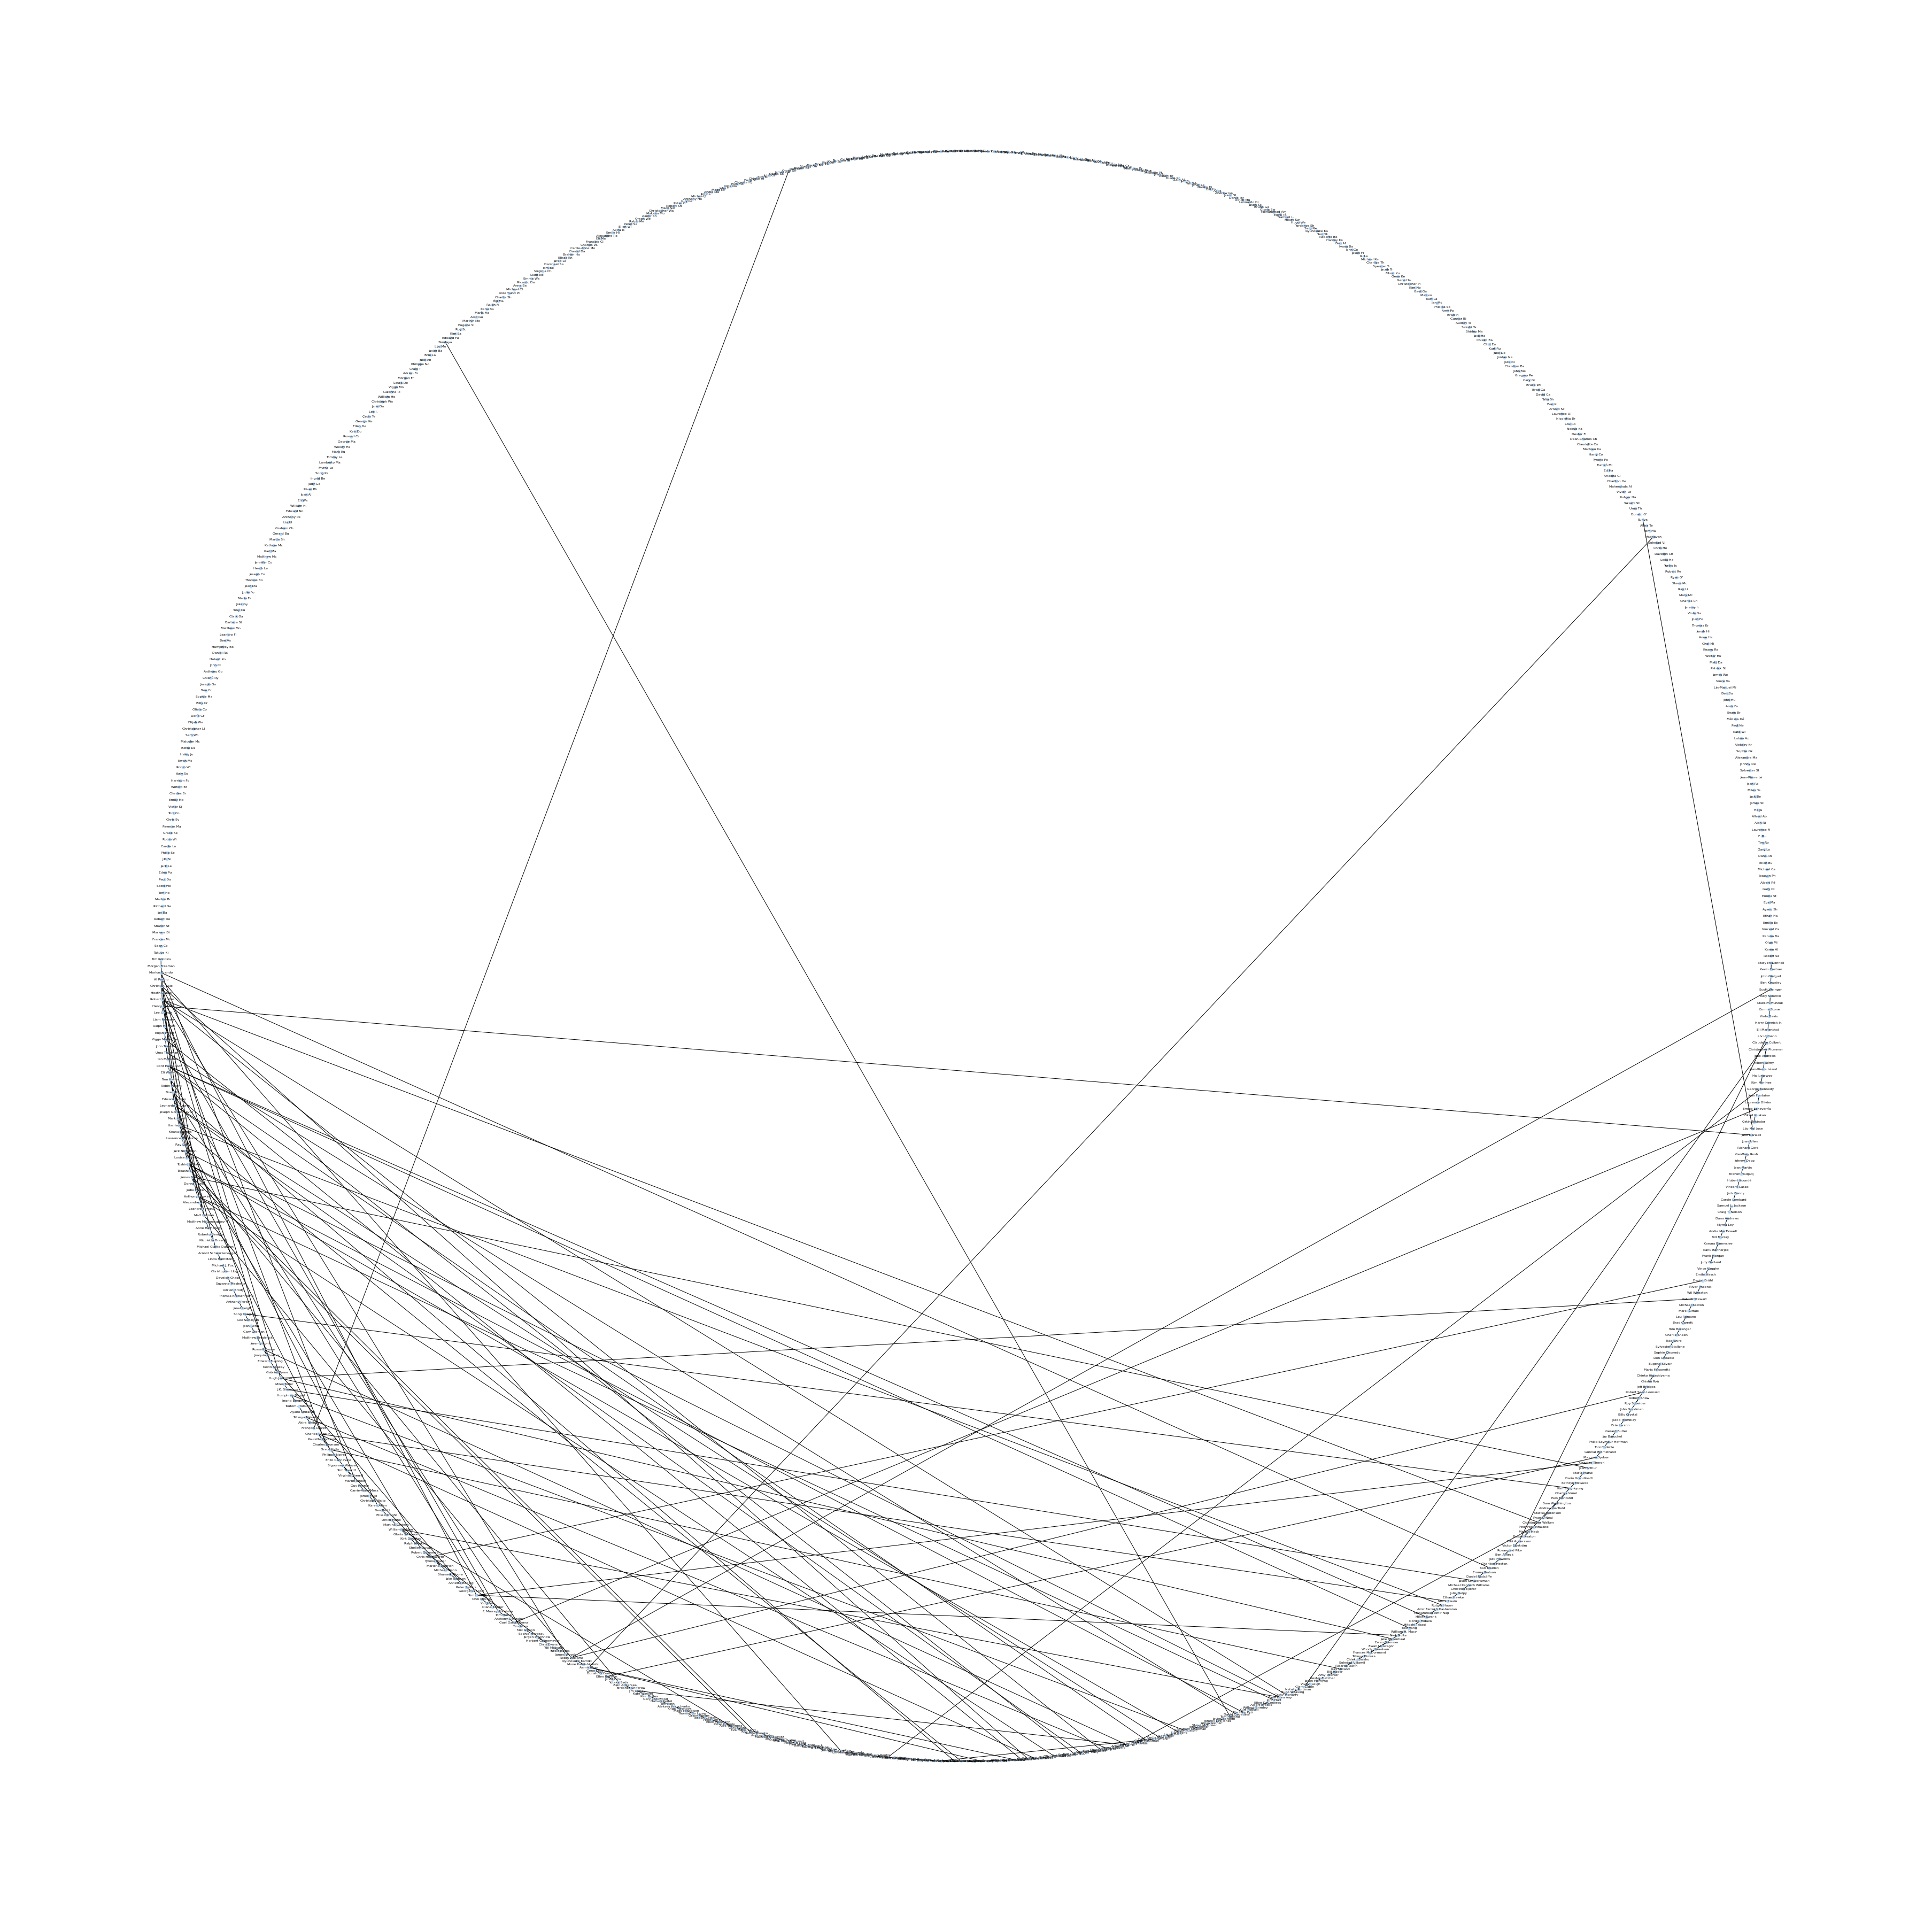

In [83]:
#was meant to make a graph with edges but got too tired to complete it.
#if you uncomment line 15-24 it'll plot the nodes of the first 7 actors.
#7 being an arbitrary value for the purpose of testing

actors = [Act.makeActor(item) for item in set_of_actors] #list of actor objects
# pprint(actors)

import math
import numpy as np


# #adding an edge between actors
# #for person in 


actor_graph = nx.Graph()
for actor in actors:
  actor_graph.add_node(actor.name)

for actorNode in crew:
  actor_graph.add_edge(actorNode[0], actorNode[1])


plt.figure(3,figsize=(50,50))
nx.draw_circular(actor_graph,
                 node_color='#bbddff',
                 font_size = 6,
                 node_size=25,
                 with_labels=True)
plt.axis('equal')
pos = nx.spring_layout(actor_graph)
nx.draw(actor_graph,pos)

# plt.show()

From here onwards I didn't do much since it was the code we wrote together

In [ ]:
movie_id = 'tt1950186' #random movie id i picked from data['items'] in 4th code block

url = f'https://imdb-api.com/en/API/FullCast/k_w26fb6h9/{movie_id}'

response = requests.request("GET", url, headers={}, data={})

data = json.loads(response.text)
# pprint(data)

fullcast=[]
fullcast = [(actor['name'],
            actor['id'],
            actor['image']) for actor in data['actors']]
# pprint(fullcast)

"""
NOTED THAT FULLCAST ABOVE CONTAINS THE CAST OF ONE MOVIE ONLY. HOWEVER,
FULLCAST IN THE CODE BELOW CONTAINS A LIST OF DICTIONARIES (MOVIE ID BEING KEY AND LIST OF ACTORS BEING VALUE)
OF ALL THE CAST MEMBERS FROM THE APIs DATABASE
MEANING IT MAKES A TOTAL OF 250 REQUESTS
"""


# fullcast = [dict(id=[(cast_member['name'], 
#                       cast_member['id'], 
#                       cast_member['image']) 
#                       for cast_member in json.loads(requests.request("GET",
#                                                                      f'https://imdb-api.com/en/API/FullCast/k_w26fb6h9/{id}', 
#                                                                      headers={}, 
#                                                                      data={}).text)['actors']])
#                                                                      for (title, id, image) in movies]


# no_picture = len([1 for tup in fullcast if 'nopicture' in tup[2]])
# no_picture

# fullcast = [[data['actors'][i]['name'], 
#              data['actors'][i]['id'], 
#              data['actors'][i]['image']] 
#             for i in range(len(data['actors']))]

In [ ]:
# Movielist = [Movie.createMovie(movieInfo[0], movieInfo[1], movieInfo[2]) for movieInfo in movies]
# pprint(Movielist)

# Actorlist = [Actor.createActor(actorInfo[0], actorInfo[1], actorInfo[2]) for actorInfo in fullcast]
# pprint(Actorlist)


MovieObjects = [Movie.createMovie(title, id, image) for (title, id, image) in movies]
pprint(MovieObjects)

ActorObjects = [Actor.createActor(name, id, image) for (name, id, image) in fullcast]
pprint(ActorObjects)